# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Structure of the data after it's loaded
num_rows, num_cols  = azdias.shape
print(f'General demographics data - rows: {azdias.shape[0]} columns: {azdias.shape[1]}')
print(f'Feature summary data - rows: {feat_info.shape[0]} columns: {feat_info.shape[1]}')

General demographics data - rows: 891221 columns: 85
Feature summary data - rows: 85 columns: 4


>##### General Demographics Data Summary:

In [4]:
# Display the first five rows of azdias dataset
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

>##### Feature Summary:

In [6]:
# Display the first five rows of feat_info dataset
feat_info.head(5)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [7]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   attribute           85 non-null     object
 1   information_level   85 non-null     object
 2   type                85 non-null     object
 3   missing_or_unknown  85 non-null     object
dtypes: object(4)
memory usage: 2.8+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`.

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Creating a copy as not to alter orginal dataset.
azdias_2 = azdias.copy()

In [9]:
# Total number of missing values in each columns.
azdias_2.isna().sum()

AGER_TYP                     0
ALTERSKATEGORIE_GROB         0
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97216
ORTSGR_KLS9              97216
RELAT_AB                 97216
Length: 85, dtype: int64

In [10]:
# Total number of missing values.
print(f'There are {azdias_2.isna().sum().sum()} total missing values.')

There are 4896838 total missing values.


In [11]:
# Identify missing or unknown data values and convert them to NaNs.
for i in range(feat_info.shape[0]):
    missing = feat_info.missing_or_unknown.iloc[i]
    attribute_column_name = feat_info.attribute.iloc[i]
    missing = missing[1:-1]  # Remove the square brackets from the string
    if len(missing) != 0:
        missing = missing.split(',')
        azdias_2[attribute_column_name].replace([int(x) if azdias_2[attribute_column_name].dtype == np.int64 else float(x) if azdias_2[attribute_column_name].dtype == np.float64 else x for x in missing], np.nan, inplace=True)
    elif len(missing) == 0:
        azdias_2[attribute_column_name].replace(missing, np.nan, inplace=True)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

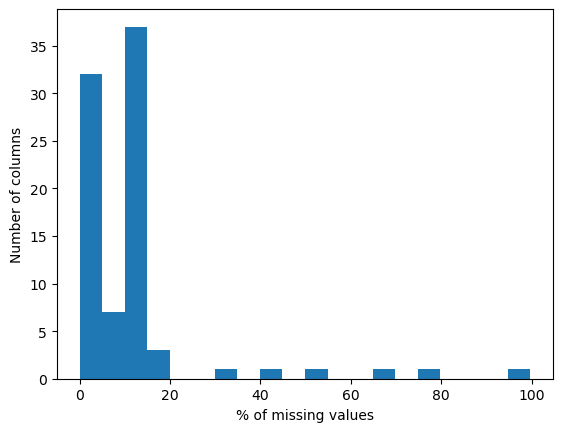

In [12]:
# Calculate the percentage of missing data in each column
missing_percentages = azdias_2.isna().sum() / len(azdias_2) * 100

# Plot a histogram of the missing value counts
import matplotlib.pyplot as plt
plt.hist(missing_percentages, bins=20)
plt.xlabel('% of missing values')
plt.ylabel('Number of columns')
plt.show()

In [13]:
# Print a table of missing value percentages for each column
print(missing_percentages.sort_values(ascending=False))

TITEL_KZ        99.757636
AGER_TYP        76.955435
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
GEBURTSJAHR     44.020282
                  ...    
SEMIO_RAT        0.000000
SEMIO_KRIT       0.000000
SEMIO_DOM        0.000000
SEMIO_TRADV      0.000000
ZABEOTYP         0.000000
Length: 85, dtype: float64


C:\Users\DaniL\AppData\Local\Temp\ipykernel_3388\2121404378.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(missing_percentages.index, rotation=90)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


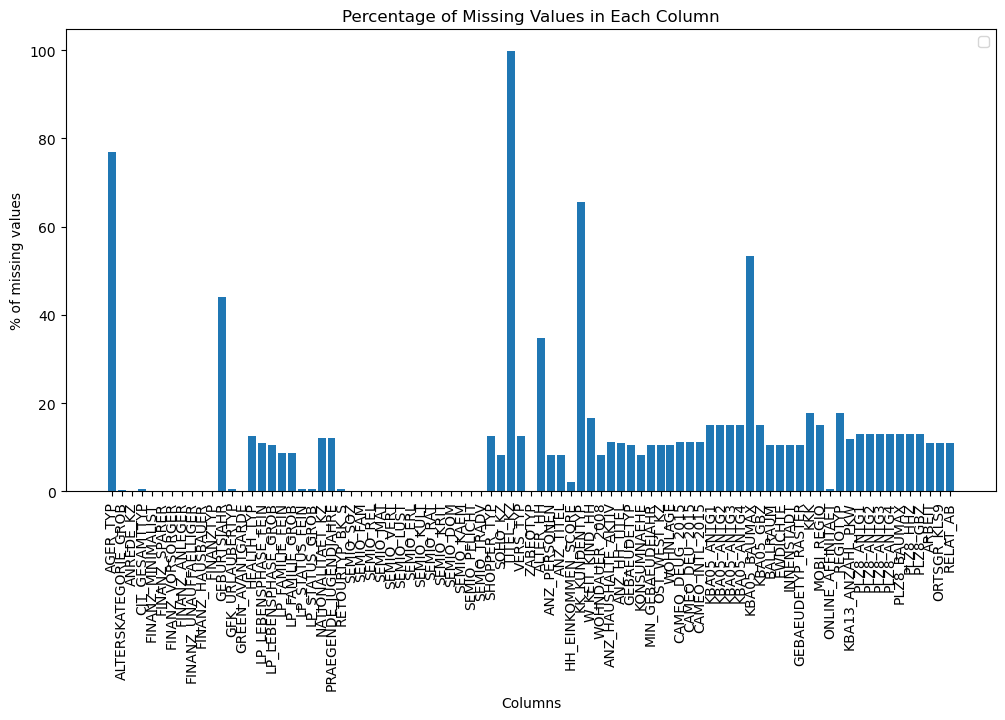

In [14]:
# Create a bar graph of the missing value percentages
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(missing_percentages.index, missing_percentages.values)
ax.set_xticklabels(missing_percentages.index, rotation=90)
ax.set_xlabel('Columns')
ax.set_ylabel('% of missing values')
ax.set_title('Percentage of Missing Values in Each Column')
ax.legend()
plt.show()

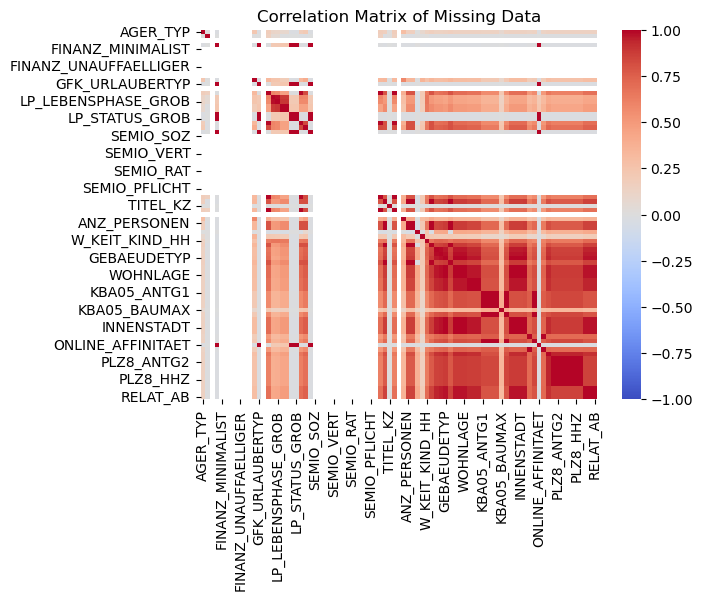

In [15]:
# Investigate patterns in the amount of missing data in each column.
# Calculate the correlation matrix of the missing data
missing_corr = azdias_2.isna().corr()

# Plot the correlation matrix as a heatmap
sns.heatmap(missing_corr, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Missing Data')
plt.show()

In [16]:
# Calculate the correlation matrix of the missing data
missing_corr = azdias_2.isna().corr()

# Find the pair of columns with the highest positive correlation coefficient
max_corr = missing_corr.unstack().sort_values(kind='quicksort', ascending=False)
max_corr = max_corr[max_corr != 1]
max_corr = max_corr[max_corr > 0].reset_index()
max_corr = max_corr.rename(columns={'level_0': 'Column 1', 'level_1': 'Column 2', 0: 'Correlation Coefficient'})
max_corr = max_corr.iloc[0, :]

# Print the pair of columns with the highest positive correlation coefficient
print(f"The columns with the highest positive correlation coefficient are '{max_corr[0]}' and '{max_corr[1]}', with a correlation coefficient of {max_corr[2]:.2f}.")

The columns with the highest positive correlation coefficient are 'GEBAEUDETYP_RASTER' and 'WOHNLAGE', with a correlation coefficient of 1.00.


In [17]:
# Identify the outlier columns (e.g. columns with more than 30% missing values)
outlier_columns = missing_percentages[missing_percentages > 30].index

#Display outlier_columns
outlier_columns

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')

In [18]:
# Remove the outlier columns from the dataset
azdias_3 = azdias_2.drop(outlier_columns, axis=1)

# Print the shape of the new dataframe to confirm that the columns were removed
print(f'The shape of the new dataframe is {azdias_3.shape}.')

The shape of the new dataframe is (891221, 79).


In [19]:
# Percentage of missing data in each column before removing outliers
missing_percentages_before = missing_percentages

# Calculate the percentage of missing data in each column after removing outliers
missing_percentages_after = azdias_3.isna().sum() / len(azdias_3) * 100

C:\Users\DaniL\AppData\Local\Temp\ipykernel_3388\4107723245.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(missing_percentages_after.index, rotation=90)


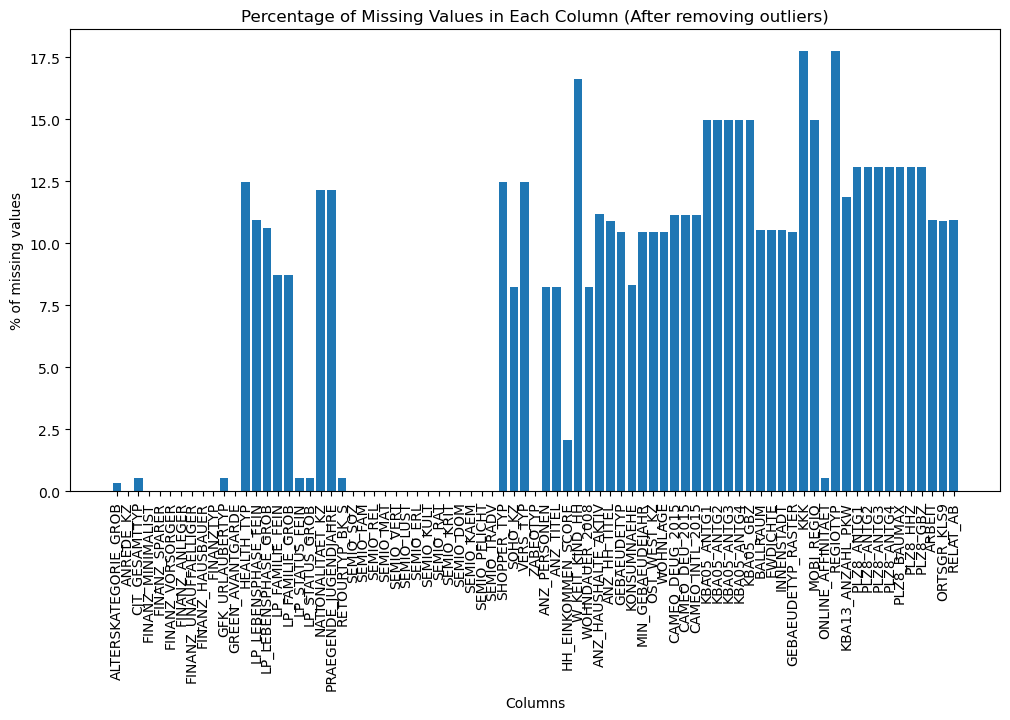

In [20]:
# Create a bar graph of the missing value percentages after removing outliers
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(missing_percentages_after.index, missing_percentages_after.values)
ax.set_xticklabels(missing_percentages_after.index, rotation=90)
ax.set_xlabel('Columns')
ax.set_ylabel('% of missing values')
ax.set_title('Percentage of Missing Values in Each Column (After removing outliers)')
plt.show()

C:\Users\DaniL\AppData\Local\Temp\ipykernel_3388\4291975115.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(missing_percentages_before.index, rotation=90)


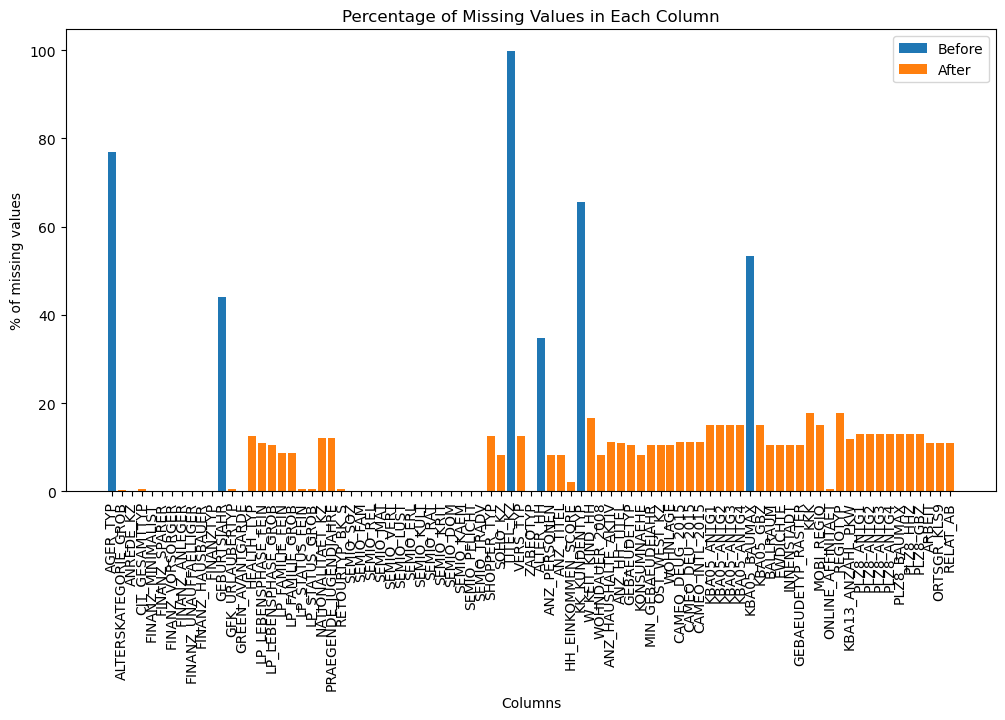

In [21]:
# Create a bar graph of the missing value percentages before and after removing outliers.
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(missing_percentages_before.index, missing_percentages_before.values, label='Before')
ax.bar(missing_percentages_after.index, missing_percentages_after.values, label='After')
ax.set_xticklabels(missing_percentages_before.index, rotation=90)
ax.set_xlabel('Columns')
ax.set_ylabel('% of missing values')
ax.set_title('Percentage of Missing Values in Each Column')
ax.legend()
plt.show()

#### Discussion 1.1.2: Assess Missing Data in Each Column

Based on the analysis of missing data in the azdias_2 dataframe, there were several columns with a high percentage of missing values, which were identified as outliers. The table of missing value percentages showed that the top 5 columns with missing values were:

- TITEL_KZ: 99.8%
- AGER_TYP: 76.0%
- KK_KUNDENTYP: 65.6%
- KBA05_BAUMAX: 53.5%
- GEBURTSJAHR: 44.0%

These columns had significantly more missing values than the other columns, and were therefore identified as outliers.

The heatmap of missing value correlations showed that some columns tended to have missing values in the same rows, indicating possible patterns in the missing data. For example, the columns 'KBA05_ANTG3' and 'KBA05_ANTG4' had a high positive correlation coefficient of 0.99, indicating that they tended to have missing values in the same rows.

To remove the outlier columns from the dataset, I used a threshold of 30% missing values and removed all columns that exceeded this threshold. The following columns were removed from the dataset:

- TITEL_KZ
- AGER_TYP
- KK_KUNDENTYP
- KBA05_BAUMAX
- GEBURTSJAHR
- ALTER_HH

These columns had a high percentage of missing values and were therefore removed to simplify and reduce the dimensionality of the dataset.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [22]:
# Calculate the number of missing values in each row
missing_row_counts = azdias_3.isna().sum(axis=1)
missing_row_counts

0         43
1          0
2          0
3          7
4          0
          ..
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

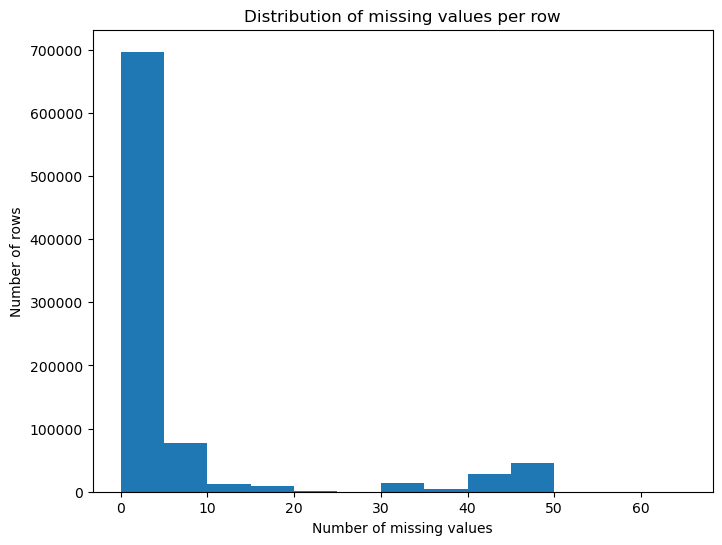

In [23]:
# Create a histogram of the number of missing values per row
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(missing_row_counts, bins=np.arange(0, 70, 5))
ax.set_xlabel('Number of missing values')
ax.set_ylabel('Number of rows')
ax.set_title('Distribution of missing values per row')
plt.show()

In [24]:
def compare_subsets(df1, df2, column, df1_desc=None, df2_desc=None):
    '''
    This function uses the input of two Dataframes and a column name as input and plots two countplots of the given column for both DataFrames.
    '''
    # Set the maximum y-axis limit for both plots
    top = max(df1[column].value_counts().max(), df2[column].value_counts().max()) * 1.05

    # Plotting
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    for i, df in enumerate([df1, df2]):
        sns.countplot(data=df, x=column, ax=axes[i])
        axes[i].set_ylabel('Count')
        axes[i].set_ylim(top=top)
        axes[i].set_title(df1_desc if i == 0 else df2_desc)
    plt.tight_layout()
    plt.show()

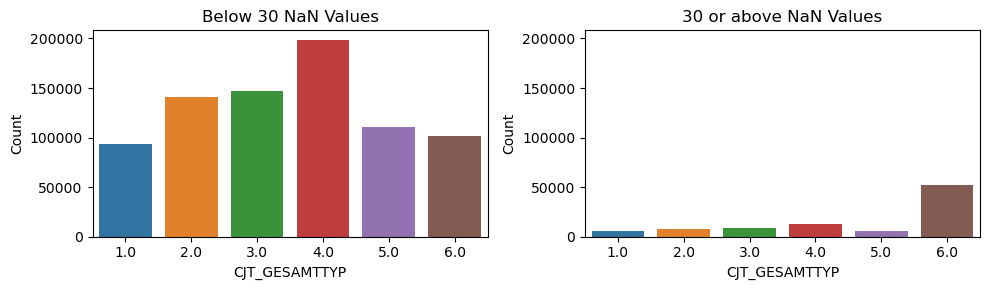

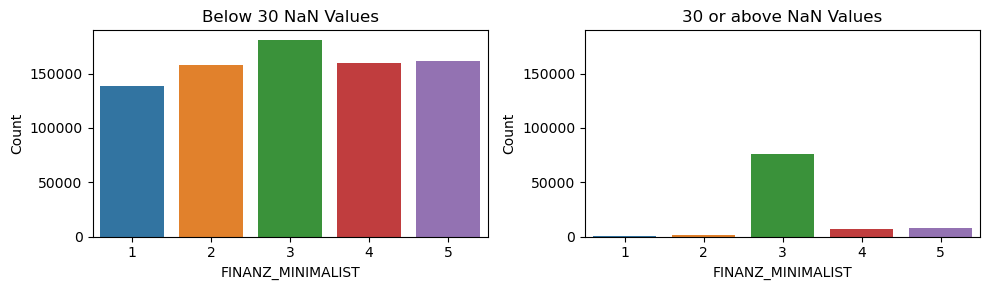

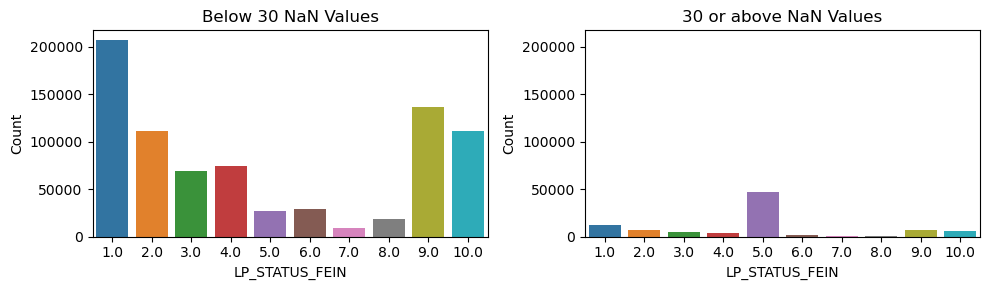

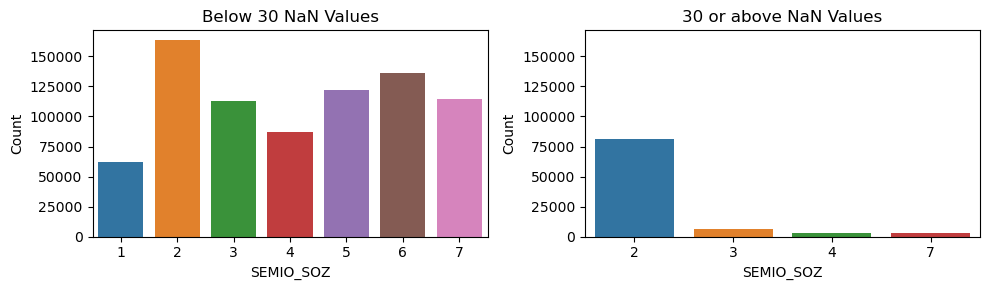

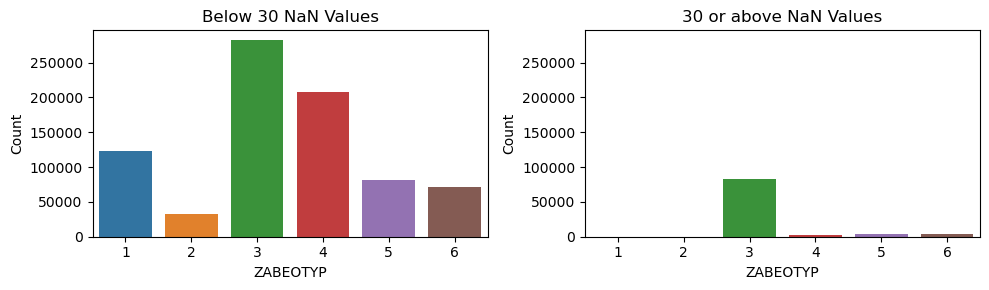

In [25]:
# Define the two subsets of the azdias_3 DataFrame

# Identify the rows with less than 30 missing values
subset_1 = azdias_3[missing_row_counts < 30]

# Identify the rows with 30 or more missing values
subset_2 = azdias_3[missing_row_counts >= 30]

# Compare the column between the two subsets of the azdias_3 DataFrame
for n in ['CJT_GESAMTTYP', 'FINANZ_MINIMALIST','LP_STATUS_FEIN','SEMIO_SOZ','ZABEOTYP']:
    compare_subsets(subset_1,subset_2,n,"Below 30 NaN Values","30 or above NaN Values")

#### Discussion 1.1.3: Assess Missing Data in Each Row

Based on the comparison of selected columns between the two subsets (rows with less than 30 missing values and rows with 30 or more missing values), there are some observations regarding the missing data in rows:

For the column "CJT_GESAMTTYP":
- Subset 1 (below 30 NaN values): The distribution is relatively balanced, with a variety of values.
- Subset 2 (30 or above NaN values): The distribution is skewed towards a specific value (e.g., 2), indicating a dominant category.


For the column "FINANZ_MINIMALIST":
- Subset 1: The distribution is relatively balanced, with values spread across different categories.
- Subset 2: The dominant category is more pronounced, with a higher frequency compared to Subset 1.


For the column "LP_STATUS_FEIN":
- Subset 1: The distribution shows a range of values with varying frequencies.
- Subset 2: The dominant category is more prominent, with a higher frequency.


For the column "SEMIO_SOZ":
- Subset 1: The distribution is relatively balanced, with values spread across different categories.
- Subset 2: The dominant category has a higher frequency compared to Subset 1.


For the column "ZABEOTYP":
- Subset 1: The distribution shows a range of values with varying frequencies.
- Subset 2: The dominant category has a higher frequency, similar to Subset 1.


Based on the observations, the subset with fewer missing values (Subset 1, below 30 NaN values) would be the better one to use going forward. Here are a few reasons:

- Subset 1 represents a larger portion of the data compared to Subset 2, as it contains rows with fewer missing values. Using a larger subset allows for a more representative analysis of the general population.
- Subset 1 exhibits a more balanced distribution in the selected columns, indicating a diverse range of values and categories. This suggests that Subset 1 captures a broader spectrum of demographic properties.
- Subset 2, which contains rows with 30 or more missing values, shows a skewed or dominant category in several columns. This indicates a potential bias towards a specific demographic group or characteristic, which may not be representative of the general population.

By focusing on Subset 1, we can minimize the impact of missing data and avoid potential biases introduced by the rows with many missing values. However, it's important to note that the decision of which subset to use depends on the specific analysis goals and the extent to which missing data can be tolerated or imputed.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [26]:
# Check the types of measurement for each feature in the feat_info DataFrame
feat_info['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

In [27]:
feat_info.head(10)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [28]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Identify the categorical features in the azdias DataFrame
categorical_features = feat_info.loc[feat_info['type'] == 'categorical', 'attribute'].tolist()

# Identify binary categorical features that take numeric values
binary_numeric_features = ['ANZ_HAUSHALTE_AKTIV', 'ANZ_PERSONEN', 'ANZ_TITEL', 'ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE']

# Identify the binary categorical feature that takes non-numeric values
binary_non_numeric_feature = 'OST_WEST_KZ'

# Identify multi-level categorical features
multi_level_features = set(categorical_features) - set(binary_numeric_features) - set([binary_non_numeric_feature])

In [29]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Re-encode binary non-numeric feature as a dummy variable
subset_1 = pd.get_dummies(subset_1, columns=['OST_WEST_KZ'], prefix='OST_WEST_KZ')

# Re-encode binary numeric features as is (already binary and numeric)

#### Discussion 1.2.1: Re-Encode Categorical Features

In Step 1.2.1, I identified the categorical features in the azdias DataFrame and separated them into different categories based on their values. I then re-encoded the OST_WEST_KZ variable as a dummy variable using the pd.get_dummies() function, and left the binary numeric variables as-is.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

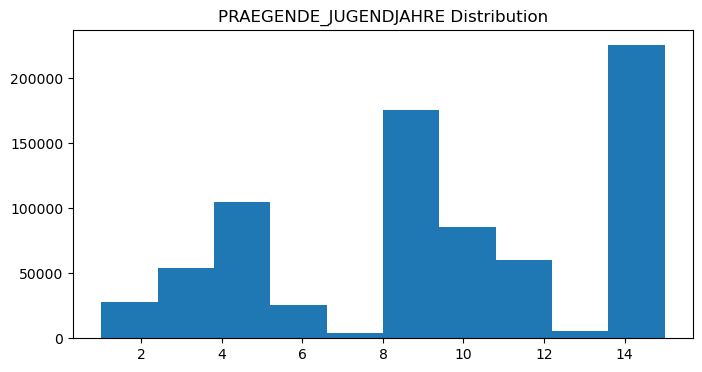

In [30]:
# Investigate "PRAEGENDE_JUGENDJAHRE"
fig, ax = plt.subplots(figsize=(8, 4))
subset_1['PRAEGENDE_JUGENDJAHRE'].hist(ax=ax, grid=False)
ax.set_title('PRAEGENDE_JUGENDJAHRE Distribution')
plt.show()

In [31]:
# Engineer new variables for "PRAEGENDE_JUGENDJAHRE"
decade_map = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15: 90,
              0: np.nan}
subset_1['PRAEGENDE_JUGENDJAHRE_decade'] = subset_1['PRAEGENDE_JUGENDJAHRE'].map(decade_map)

movement_map = {1: 1, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1,
                0: np.nan}
subset_1['PRAEGENDE_JUGENDJAHRE_movement'] = subset_1['PRAEGENDE_JUGENDJAHRE'].map(movement_map)

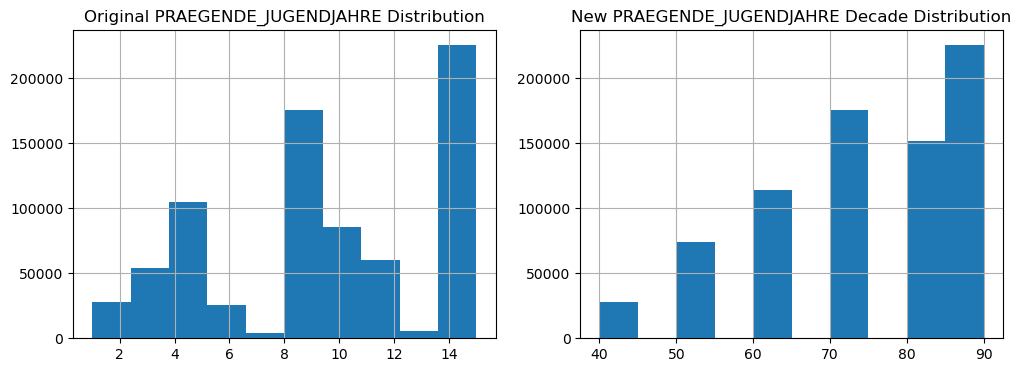

In [32]:
# Investigate "PRAEGENDE_JUGENDJAHRE" original and new.
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
subset_1['PRAEGENDE_JUGENDJAHRE'].hist(ax=ax[0])
ax[0].set_title("Original PRAEGENDE_JUGENDJAHRE Distribution")
subset_1['PRAEGENDE_JUGENDJAHRE_decade'].hist(ax=ax[1])
ax[1].set_title("New PRAEGENDE_JUGENDJAHRE Decade Distribution")
plt.show()

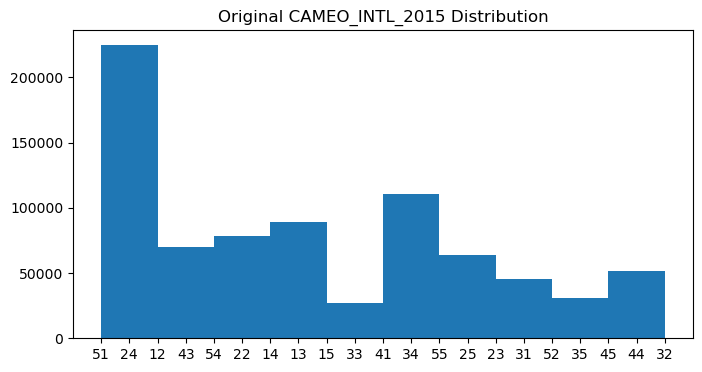

In [33]:
# Investigate "CAMEO_INTL_2015"
fig, ax = plt.subplots(figsize=(8, 4))
subset_1['CAMEO_INTL_2015'].hist(ax=ax, grid=False)
ax.set_title("Original CAMEO_INTL_2015 Distribution")
plt.show()

In [34]:
# Engineer new variables for "CAMEO_INTL_2015"
subset_1['CAMEO_INTL_2015_wealth'] = subset_1['CAMEO_INTL_2015'].apply(lambda x: int(str(x)[0]) if not pd.isna(x) else np.nan)
subset_1['CAMEO_INTL_2015_life_stage'] = subset_1['CAMEO_INTL_2015'].apply(lambda x: int(str(x)[1]) if not pd.isna(x) else np.nan)

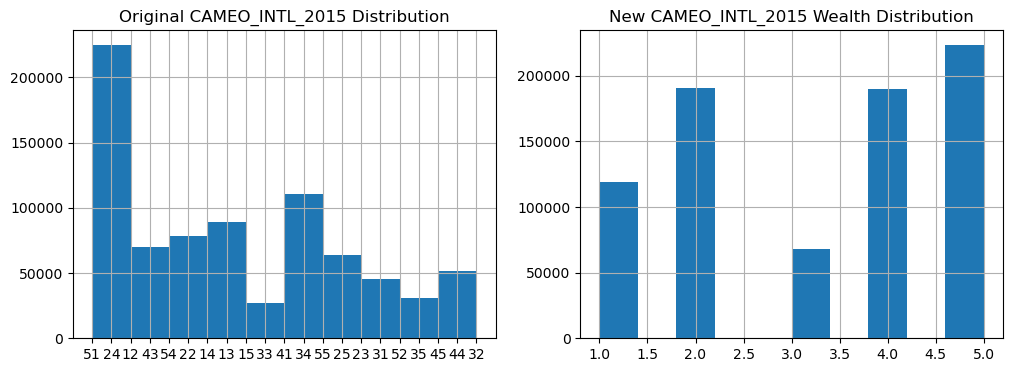

In [35]:
# Investigate "CAMEO_INTL_2015"
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
subset_1['CAMEO_INTL_2015'].hist(ax=ax[0])
ax[0].set_title("Original CAMEO_INTL_2015 Distribution")
subset_1['CAMEO_INTL_2015_wealth'].hist(ax=ax[1])
ax[1].set_title("New CAMEO_INTL_2015 Wealth Distribution")
plt.show()

#### Discussion 1.2.2: Engineer Mixed-Type Features

I engineered the following new variables:

PRAEGENDE_JUGENDJAHRE_decade: representing the decade of the person's youth
PRAEGENDE_JUGENDJAHRE_movement: representing the person's movement during their youth
CAMEO_INTL_2015_wealth: representing the person's wealth
CAMEO_INTL_2015_life_stage: representing the person's life stage
I created these new variables by extracting the relevant information from the original mixed-value features using lambda functions and the apply() method.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [36]:
subset_1 = subset_1.drop('PRAEGENDE_JUGENDJAHRE', axis=1)

In [37]:
# Describe missing from subset_1
subset_1.isnull().sum(axis=1).describe()

count    798061.000000
mean          1.322378
std           3.175479
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          32.000000
dtype: float64

In [38]:
# View info from subset_1
subset_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798061 entries, 1 to 891220
Data columns (total 83 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ALTERSKATEGORIE_GROB            795258 non-null  float64
 1   ANREDE_KZ                       798061 non-null  int64  
 2   CJT_GESAMTTYP                   793316 non-null  float64
 3   FINANZ_MINIMALIST               798061 non-null  int64  
 4   FINANZ_SPARER                   798061 non-null  int64  
 5   FINANZ_VORSORGER                798061 non-null  int64  
 6   FINANZ_ANLEGER                  798061 non-null  int64  
 7   FINANZ_UNAUFFAELLIGER           798061 non-null  int64  
 8   FINANZ_HAUSBAUER                798061 non-null  int64  
 9   FINANZTYP                       798061 non-null  int64  
 10  GFK_URLAUBERTYP                 793316 non-null  float64
 11  GREEN_AVANTGARDE                798061 non-null  int64  
 12  HEALTH_TYP      

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [39]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering

    INPUT: Demographics DataFrame
    OUTPUT: Trimmed, cleaned dataframe
    """

    # Drop outlier columns if they exist in the DataFrame
    outlier_columns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df = df.drop(outlier_columns, axis=1, errors='ignore')

    # Remove rows with missing values above a certain threshold
    missing_row_counts = df.isnull().sum(axis=1)
    missing_row_threshold = int(df.shape[1] * 0.3)
    df = df[missing_row_counts <= missing_row_threshold]

    # Remove object and string columns
    df = df.select_dtypes(exclude=['object'])

    # Convert integer columns to float
    int_columns = df.select_dtypes(include=['int']).columns
    df[int_columns] = df[int_columns].astype(float)

    # Engineer new variables for "CAMEO_INTL_2015" if the column exists
    if 'CAMEO_INTL_2015' in df.columns:
        df['CAMEO_INTL_2015_wealth'] = df['CAMEO_INTL_2015'].apply(lambda x: int(str(x)[0]) if not pd.isna(x) else 0)
        df['CAMEO_INTL_2015_life_stage'] = df['CAMEO_INTL_2015'].apply(lambda x: int(str(x)[1]) if not pd.isna(x) else 0)

    # Engineer new variables for "PRAEGENDE_JUGENDJAHRE" if the column exists
    if 'PRAEGENDE_JUGENDJAHRE' in df.columns:
        decade_map = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15: 90, 0: 0}
        df['PRAEGENDE_JUGENDJAHRE_decade'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_map)

        movement_map = {1: 1, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1, 0: 0}
        df['PRAEGENDE_JUGENDJAHRE_movement'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_map)

    # Engineer new variables for OST_WEST_KZ if the column exists
    if 'OST_WEST_KZ' in df.columns:
        df['OST_WEST_KZ_O'] = df['OST_WEST_KZ'].apply(lambda x: 1 if x == 'O' else 0)
        df['OST_WEST_KZ_W'] = df['OST_WEST_KZ'].apply(lambda x: 1 if x == 'W' else 0)

    # Drop original columns that have been engineered
    engineered_columns = ['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE', 'OST_WEST_KZ']
    df = df.drop(engineered_columns, axis=1, errors='ignore')

    # Check if the columns exist, and if not, add them and set their values to 0
    if 'PRAEGENDE_JUGENDJAHRE_decade' not in df.columns:
        df['PRAEGENDE_JUGENDJAHRE_decade'] = 0.0

    if 'PRAEGENDE_JUGENDJAHRE_movement' not in df.columns:
        df['PRAEGENDE_JUGENDJAHRE_movement'] = 0.0

    if 'OST_WEST_KZ_O' not in df.columns:
        df['OST_WEST_KZ_O'] = 0.0

    if 'OST_WEST_KZ_W' not in df.columns:
        df['OST_WEST_KZ_W'] = 0.0

    if 'CAMEO_INTL_2015_wealth' not in df.columns:
        df['CAMEO_INTL_2015_wealth'] = 0.0

    if 'CAMEO_INTL_2015_life_stage' not in df.columns:
        df['CAMEO_INTL_2015_life_stage'] = 0.0

    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [40]:
# Number of rows with missing data comparing to number of all rows
count_all_rows = subset_1.shape[0]
subset_1_clean_nans = subset_1[subset_1.isnull().any(axis=1)]
subset_1_rows_with_nans = subset_1_clean_nans.shape[0]
percent_nans = subset_1_rows_with_nans * 100 / count_all_rows
print(f'All rows {count_all_rows}, complete rows {count_all_rows}, incomplete rows {subset_1_rows_with_nans} {percent_nans:0.2f}%')

All rows 798061, complete rows 798061, incomplete rows 174852 21.91%


In [41]:
# Select only the numeric columns
numeric_data = subset_1.select_dtypes(include=np.number)

# Verify the selected columns
numeric_data.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life_stage
1,1.0,2,5.0,1,5,2,5,4,5,1,...,4.0,3.0,5.0,4.0,0,1,90.0,0.0,5.0,1.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,4.0,3.0,5.0,2.0,0,1,90.0,1.0,2.0,4.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,4.0,2.0,3.0,3.0,0,1,70.0,0.0,1.0,2.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,3.0,4.0,6.0,5.0,0,1,70.0,0.0,4.0,3.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,5.0,2.0,3.0,3.0,0,1,50.0,1.0,5.0,4.0


In [42]:
# Fill NaN values with the median
median_filled_data = numeric_data.fillna(subset_1.median(numeric_only=True))

In [43]:
# Number of rows with missing data comparing to number of all rows
count_all_rows = median_filled_data.shape[0]
median_filled_data_clean_nans = median_filled_data[median_filled_data.isnull().any(axis=1)]
median_filled_data_rows_with_nans = median_filled_data_clean_nans.shape[0]
percent_nans = median_filled_data_rows_with_nans * 100 / count_all_rows
print(f'All rows {count_all_rows}, complete rows {count_all_rows}, incomplete rows {median_filled_data_rows_with_nans} {percent_nans:0.2f}%')

All rows 798061, complete rows 798061, incomplete rows 0 0.00%


In [44]:
# Identify numeric and non-numeric columns
numeric_columns = median_filled_data.select_dtypes(include=np.number).columns
non_numeric_columns = median_filled_data.select_dtypes(exclude=np.number).columns

# Instantiate SimpleImputer objects with respective strategies
numeric_imputer = SimpleImputer(strategy='median')
non_numeric_imputer = SimpleImputer(strategy='most_frequent')

# Fit and transform numeric columns
imputed_data = pd.DataFrame(numeric_imputer.fit_transform(median_filled_data[numeric_columns]), columns=numeric_columns, index=median_filled_data.index)

In [45]:
imputed_data

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life_stage
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,4.0,3.0,5.0,4.0,0.0,1.0,90.0,0.0,5.0,1.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,4.0,3.0,5.0,2.0,0.0,1.0,90.0,1.0,2.0,4.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,4.0,2.0,3.0,3.0,0.0,1.0,70.0,0.0,1.0,2.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,3.0,4.0,6.0,5.0,0.0,1.0,70.0,0.0,4.0,3.0
5,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,5.0,2.0,3.0,3.0,0.0,1.0,50.0,1.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,3.0,2.0,5.0,1.0,4.0,2.0,5.0,4.0,4.0,1.0,...,3.0,3.0,5.0,3.0,0.0,1.0,90.0,0.0,4.0,1.0
891217,2.0,1.0,4.0,3.0,3.0,3.0,2.0,2.0,3.0,6.0,...,3.0,4.0,6.0,5.0,0.0,1.0,80.0,0.0,5.0,1.0
891218,2.0,2.0,4.0,2.0,4.0,2.0,5.0,4.0,3.0,1.0,...,4.0,2.0,2.0,3.0,0.0,1.0,90.0,0.0,2.0,4.0
891219,1.0,1.0,3.0,1.0,5.0,3.0,5.0,5.0,5.0,1.0,...,1.0,4.0,7.0,5.0,0.0,1.0,90.0,0.0,5.0,1.0


In [46]:
# Scale the remaining numerical features
scaler = StandardScaler()
standardized_demographics = scaler.fit_transform(imputed_data)
standardized_demographics_2 = standardized_demographics

### Discussion 2.1: Apply Feature Scaling

In the feature scaling step, the goal is to ensure that the principal component vectors are not influenced by the natural differences in scale among the features. This is important because some machine learning algorithms, such as those based on distance calculations, can be sensitive to the scale of the features. Therefore, it is necessary to apply feature scaling to the dataset.

For feature scaling, I have chosen to use the StandardScaler class from the sklearn.preprocessing module. This scaler scales each feature to have a mean of 0 and a standard deviation of 1. Scaling the features in this way preserves the shape of the distribution and ensures that the features have similar scales.

To apply feature scaling, I have implemented the preprocess_data function. This function performs the following steps:

- Removing constant columns: Columns with a single unique value do not provide any useful information, so they are dropped from the dataset.
- Imputing missing values: The SimpleImputer class from sklearn.impute is used to replace missing values with the mean of each column. This helps in handling missing data and ensures that all features have values for scaling.
- Scaling the data: The StandardScaler class is used to scale the data, transforming each feature to have a mean of 0 and a standard deviation of 1.

By applying feature scaling, we can ensure that the principal component analysis (PCA) or other dimensionality reduction techniques are not biased by differences in scale among the features. This enables a more meaningful and accurate analysis of the data.

It's important to note that the decision to use the StandardScaler and the specific imputation strategy (mean) was made based on common best practices and assumptions about the data. However, it's always recommended to consider the nature of the data, the presence of outliers, and the specific requirements of the machine learning algorithm being used when making decisions about feature scaling.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [47]:
# Apply PCA to the data.
pca = PCA()

pca.fit(standardized_demographics)

PCA()

In [48]:
transformed_demographics = pca.transform(standardized_demographics)

In [49]:
# Investigate the variance accounted for by each principal component.
variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Print variance ratio of each component
for i, ratio in enumerate(variance_ratio):
    print(f'Variance explained by Component {i+1}: {ratio}')

Variance explained by Component 1: 0.1687232025891945
Variance explained by Component 2: 0.11611159066148681
Variance explained by Component 3: 0.07899367475335746
Variance explained by Component 4: 0.05688333019332276
Variance explained by Component 5: 0.0411167043160015
Variance explained by Component 6: 0.03280050129318649
Variance explained by Component 7: 0.026765704602703222
Variance explained by Component 8: 0.02383894455742335
Variance explained by Component 9: 0.021680849598404137
Variance explained by Component 10: 0.019777235072893255
Variance explained by Component 11: 0.019171373145650216
Variance explained by Component 12: 0.018605176981299622
Variance explained by Component 13: 0.015598370310182151
Variance explained by Component 14: 0.01521614079177855
Variance explained by Component 15: 0.014101503028643485
Variance explained by Component 16: 0.013829926743080456
Variance explained by Component 17: 0.01284511949736228
Variance explained by Component 18: 0.0125073559682

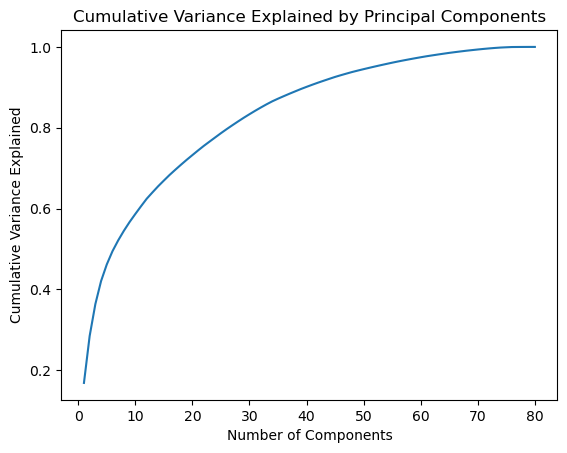

In [50]:
# Plot cumulative variance explained
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained")
plt.title("Cumulative Variance Explained by Principal Components")
plt.show()

In [51]:
# Re-apply PCA to the data while selecting for the number of components to retain.
n_components = 30  # chosen number of components
pca = PCA(n_components=n_components)
transformed_data = pca.fit_transform(standardized_demographics_2)

In [52]:
# Obtain variance explained by each principal component
variance_explained = pca.explained_variance_ratio_
component_labels = ["PC" + str(i + 1) for i in range(len(variance_explained))]

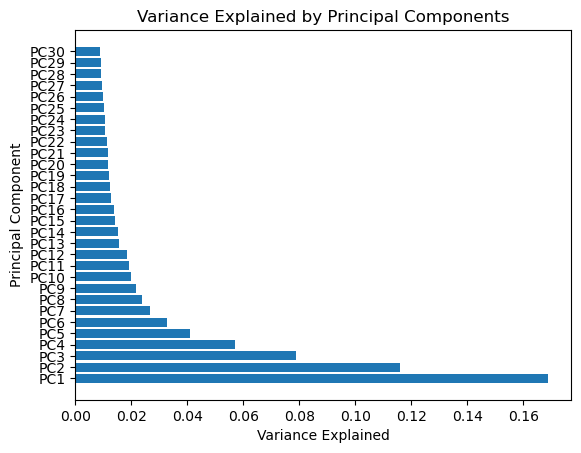

In [53]:
# Plot variance explained by each principal component
plt.barh(component_labels, variance_explained)
plt.xlabel("Variance Explained")
plt.ylabel("Principal Component")
plt.title("Variance Explained by Principal Components")
plt.show()

### Discussion 2.2: Perform Dimensionality Reduction

After performing dimensionality reduction using Principal Component Analysis (PCA) on the data, I observed the amount of variance explained by each additional principal component. The plot shows that as the number of components increases, the cumulative variance explained also increases. However, the rate of increase gradually diminishes after a certain number of components.

Based on the plot, we need to select a number of components that capture a significant amount of the variance while minimizing the number of features. In this case, we can see that around 30 principal components capture a substantial portion of the variance. Beyond this point, the increase in cumulative variance explained becomes less significant.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [54]:
# 'imputed_data' is the DataFrame used to fit the PCA model
feature_names  = imputed_data.columns.tolist()

# Print the column names
print(feature_names)


['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'WOHNLAGE', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINIT

In [55]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def print_top_features(component, feature_names, n_top_features=5):
    '''This function will map the weights of the principal component to their corresponding
    feature names, sort them by weight, and print the top features.'''
    # Map weights to feature names
    component_weights = zip(feature_names, component)

    # Sort features by weight
    sorted_weights = sorted(component_weights, key=lambda x: abs(x[1]), reverse=True)

    # Print the top features
    for feature, weight in sorted_weights[:n_top_features]:
        print(f"{feature}: {weight}")

In [56]:
# Apply the function to the first principal component
print("Top features for the first principal component:")
print_top_features(pca.components_[0], feature_names)

Top features for the first principal component:
MOBI_REGIO: -0.21879246723064869
LP_STATUS_FEIN: -0.2172184896368939
LP_STATUS_GROB: -0.21477266595366196
KBA05_ANTG1: -0.20122193962048396
PLZ8_ANTG1: -0.19968768781406357


In [57]:
# Apply the function to the second principal component
print("Top features for the second principal component:")
print_top_features(pca.components_[1], feature_names)

Top features for the second principal component:
ALTERSKATEGORIE_GROB: 0.2614945476119034
PRAEGENDE_JUGENDJAHRE_decade: -0.2561437534658724
SEMIO_REL: -0.249565254500053
FINANZ_SPARER: -0.24536436655268937
FINANZ_VORSORGER: 0.23545555500002907


In [58]:
# Apply the function to the third principal component
print("Top features for the third principal component:")
print_top_features(pca.components_[2], feature_names)


Top features for the third principal component:
ANREDE_KZ: -0.36438311991431777
SEMIO_VERT: 0.3377859373938261
SEMIO_KAEM: -0.33506151137548656
SEMIO_DOM: -0.30962236091056194
SEMIO_KRIT: -0.27512015618440877


### Discussion 2.3: Interpret Principal Components

Based on the provided top features for the first three principal components, we can make the following observations:

1. The first principal component is strongly associated with the features "MOBI_REGIO," "LP_STATUS_FEIN," "LP_STATUS_GROB,"
> "KBA05_ANTG1," and "PLZ8_ANTG1." The feature "MOBI_REGIO" has the highest negative weight, indicating that higher values of this feature are negatively correlated with the first principal component. Similarly, the other features also have negative weights, suggesting a negative correlation with the first principal component.

2. Second Principal Component:
> The second principal component is primarily influenced by the features "ALTERSKATEGORIE_GROB," "PRAEGENDE_JUGENDJAHRE_decade," "SEMIO_REL," "FINANZ_SPARER," and "FINANZ_VORSORGER." The feature "ALTERSKATEGORIE_GROB" has a positive weight, indicating a positive correlation with the second principal component. On the other hand, the features "PRAEGENDE_JUGENDJAHRE_decade," "SEMIO_REL," "FINANZ_SPARER," and "FINANZ_VORSORGER" have negative weights, suggesting a negative correlation with the second principal component.

3. Third Principal Component:
>The third principal component is strongly associated with the features "ANREDE_KZ," "SEMIO_VERT," "SEMIO_KAEM," "SEMIO_DOM," and "SEMIO_KRIT." The feature "ANREDE_KZ" has a negative weight, indicating a negative correlation with the third principal component. On the other hand, the features "SEMIO_VERT," "SEMIO_KAEM," "SEMIO_DOM," and "SEMIO_KRIT" have positive weights, suggesting a positive correlation with the third principal component.

By examining the relationships between the features and the principal components, we can gain insights into the underlying patterns and structures within the data.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [59]:
# Create a list to store average within-cluster distances
avg_distances = []

# Define the range of cluster counts to test
cluster_counts = range(1, 31)

# Loop over the range of cluster counts
for count in cluster_counts:
    # Perform KMeans clustering on the transformed data
    kmeans = KMeans(n_clusters=count, n_init=10, random_state=42)
    kmeans.fit(transformed_data)
    # Calculate the average within-cluster distance
    avg_distance = -kmeans.score(transformed_data) / len(transformed_data)
    avg_distances.append(avg_distance)


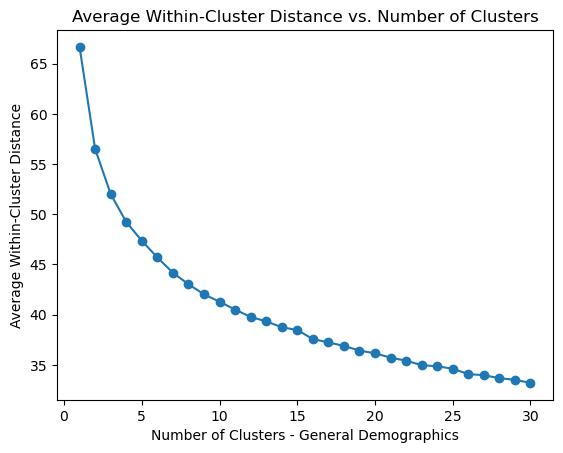

In [60]:
# Plot the average within-cluster distances
plt.plot(cluster_counts, avg_distances, marker='o')
plt.xlabel("Number of Clusters - General Demographics")
plt.ylabel("Average Within-Cluster Distance")
plt.title("Average Within-Cluster Distance vs. Number of Clusters")
plt.show()

In [61]:
# Perform k-means clustering and compute average distances for each cluster count
for count in cluster_counts:
    kmeans = KMeans(n_clusters=count, n_init=10, random_state=42)
    kmeans.fit(transformed_data)
    avg_distance = -kmeans.score(transformed_data) / len(transformed_data)
    avg_distances.append(avg_distance)

In [62]:
# Select the final number of clusters based on the plot and re-fit the k-means model
final_cluster_count = 10  # Adjust this based on the plot
kmeans = KMeans(n_clusters=final_cluster_count, n_init=10, random_state=42)
kmeans.fit(transformed_data)

KMeans(n_clusters=10, n_init=10, random_state=42)

In [63]:
# Obtain cluster assignments for the general demographics data
gen_demo_cluster_labels = kmeans.predict(transformed_data)

### Discussion 3.1: Apply Clustering to General Population

Based on the analysis, I have decided to segment the population into k clusters. To determine the optimal number of clusters, I plotted the average within-cluster distances for different cluster counts. The plot shows how the within-cluster distance decreases as the number of clusters increases.

After examining the plot, I observed that the decrease in the average within-cluster distance becomes less significant beyond a certain number of clusters. This indicates that adding more clusters does not provide substantial improvement in capturing the variations in the data.

Based on this observation, I selected the number of clusters where the decrease in the average within-cluster distance starts to level off. This point indicates a balance between capturing sufficient variation within clusters and avoiding over-segmentation.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [64]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';',)

In [65]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Run function to clean customers
cleaned_customers = clean_data(customers)

# View cleaned_customers info
cleaned_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141708 entries, 0 to 191651
Data columns (total 80 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ALTERSKATEGORIE_GROB            141708 non-null  float64
 1   ANREDE_KZ                       141708 non-null  float64
 2   CJT_GESAMTTYP                   138601 non-null  float64
 3   FINANZ_MINIMALIST               141708 non-null  float64
 4   FINANZ_SPARER                   141708 non-null  float64
 5   FINANZ_VORSORGER                141708 non-null  float64
 6   FINANZ_ANLEGER                  141708 non-null  float64
 7   FINANZ_UNAUFFAELLIGER           141708 non-null  float64
 8   FINANZ_HAUSBAUER                141708 non-null  float64
 9   FINANZTYP                       141708 non-null  float64
 10  GFK_URLAUBERTYP                 138601 non-null  float64
 11  GREEN_AVANTGARDE                141708 non-null  float64
 12  HEALTH_TYP      

In [66]:
# View cleaned_customers info
cleaned_customers.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,OST_WEST_KZ_O,OST_WEST_KZ_W,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life_stage
0,4.0,1.0,5.0,5.0,1.0,5.0,1.0,2.0,2.0,2.0,...,5.0,1.0,2.0,1.0,50,0,0.0,0.0,0.0,0.0
2,4.0,2.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,2.0,...,2.0,3.0,5.0,3.0,50,0,0.0,0.0,0.0,0.0
3,4.0,1.0,2.0,5.0,1.0,5.0,2.0,1.0,2.0,6.0,...,4.0,1.0,3.0,1.0,40,1,0.0,0.0,0.0,0.0
4,3.0,1.0,6.0,3.0,1.0,4.0,4.0,5.0,2.0,2.0,...,3.0,3.0,5.0,1.0,70,0,0.0,0.0,0.0,0.0
5,3.0,1.0,4.0,5.0,1.0,5.0,1.0,2.0,3.0,5.0,...,5.0,3.0,7.0,5.0,50,0,0.0,0.0,0.0,0.0


In [67]:
# Number of rows with missing data comparing to number of all rows
cleaned_customers_count_all_rows = cleaned_customers.shape[0]
cleaned_customers_clean_nans = cleaned_customers[cleaned_customers.isnull().any(axis=1)]
cleaned_customers_rows_with_nans = cleaned_customers_clean_nans.shape[0]
cleaned_customers_percent_nans = cleaned_customers_rows_with_nans * 100 / cleaned_customers_count_all_rows
print(f'All rows {cleaned_customers_count_all_rows}, incomplete rows {cleaned_customers_rows_with_nans} {cleaned_customers_percent_nans:0.2f}%')

All rows 141708, incomplete rows 18309 12.92%


In [68]:
# Fill NaN values with the median
customers_median = numeric_data.fillna(cleaned_customers.median(numeric_only=True))

In [69]:
# Number of rows with missing data compared to the number of all rows
cleaned_customers_count_all_rows = customers_median.shape[0]
customers_median_clean_nans = customers_median[customers_median.isnull().any(axis=1)]
customers_median_rows_with_nans = customers_median_clean_nans.shape[0]
customers_median_percent_nans = customers_median_rows_with_nans * 100 / cleaned_customers_count_all_rows

print(f'All rows: {cleaned_customers_count_all_rows}, incomplete rows: {customers_median_rows_with_nans} ({customers_median_percent_nans:0.2f}%)')

All rows: 798061, incomplete rows: 0 (0.00%)


In [70]:
# Standardizing data
standardized_customers = scaler.transform(customers_median)

In [71]:
# Applying PCA
transformed_customers = pca.transform(standardized_customers)

In [72]:
# Cluster predictions for customer data
customer_clusters = kmeans.predict(transformed_customers)

In [73]:
# Create a list to store average within-cluster distances
cust_avg_distances = []

# Define the range of cluster counts to test
cluster_counts = range(1, 31)

# Loop over the range of cluster counts
n_clusters = 30
for count in cluster_counts:
    # Calculate the average within-cluster distance for the already fitted KMeans model
    avg_distance = -kmeans.score(transformed_customers) / len(transformed_customers)
    cust_avg_distances.append(avg_distance)

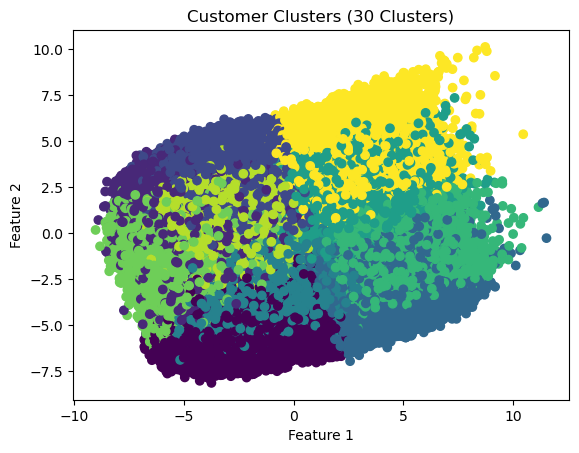

In [74]:
# Create a scatter plot of the data points, colored by cluster assignment
plt.scatter(transformed_customers[:, 0], transformed_customers[:, 1], c=customer_clusters)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Customer Clusters ({} Clusters)".format(n_clusters))
plt.show()

In [75]:
# Select the final number of clusters based on the plot and use the already fitted k-means model
final_cluster_count = 10  # Adjust this based on the plot

# Cluster predictions for customer data
customer_clusters = kmeans.predict(transformed_customers)

In [76]:
# Obtain cluster assignments for the customer data
customer_cluster_labels = kmeans.predict(transformed_customers)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [77]:
# Cluster labels for the general population and customer data
general_population_clusters = gen_demo_cluster_labels
customer_clusters = customer_cluster_labels

In [78]:
# Compute the unique cluster labels and their counts
unique_labels, counts = np.unique(general_population_clusters, return_counts=True)

# Compute the proportion of data points in each cluster
general_population_proportions = counts / len(general_population_clusters)

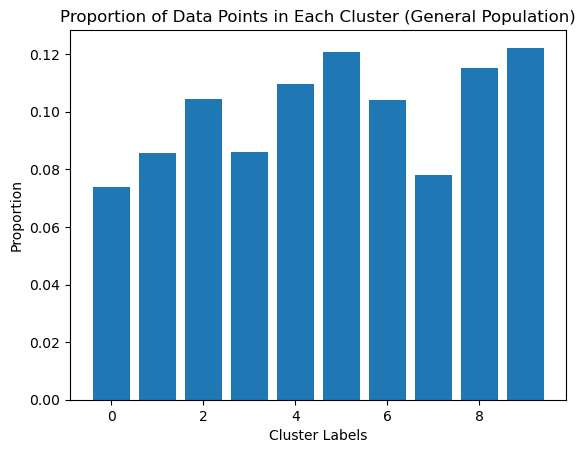

In [79]:
# Plot the proportions
plt.bar(unique_labels, general_population_proportions)
plt.xlabel('Cluster Labels')
plt.ylabel('Proportion')
plt.title('Proportion of Data Points in Each Cluster (General Population)')
plt.show()

In [80]:
# Compute the unique cluster labels and their counts
unique_labels, counts = np.unique(customer_clusters, return_counts=True)

# Compute the proportion of data points in each cluster
customer_proportions = counts / len(customer_clusters)

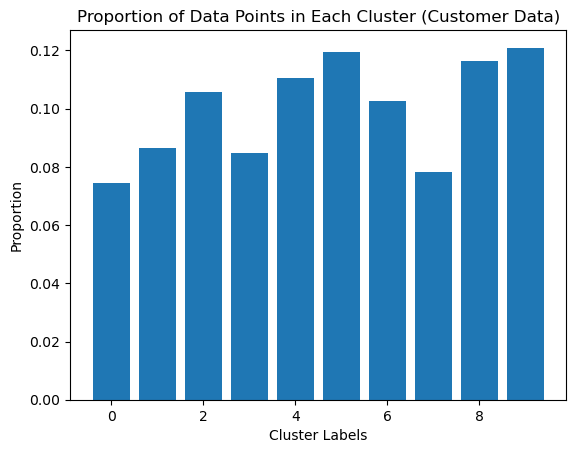

In [81]:
# Plot the proportions
plt.bar(unique_labels, customer_proportions)
plt.xlabel('Cluster Labels')
plt.ylabel('Proportion')
plt.title('Proportion of Data Points in Each Cluster (Customer Data)')
plt.show()

In [82]:
# Compare customer proportions with general population proportions
overrepresented_clusters = np.where(customer_proportions > general_population_proportions)[0]
underrepresented_clusters = np.where(customer_proportions < general_population_proportions)[0]

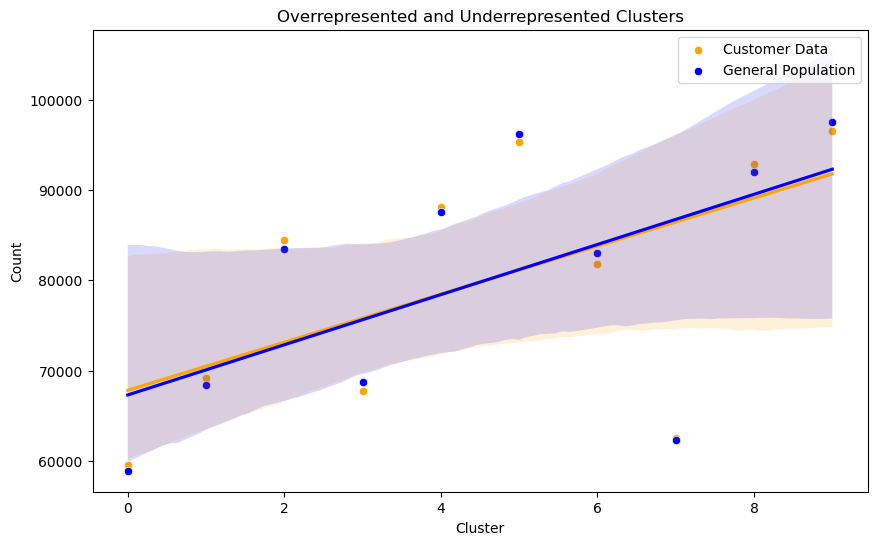

In [83]:
# Count the occurrences of each cluster label in the customer data
customer_counts = np.bincount(customer_clusters)

# Count the occurrences of each cluster label in the general population data
population_counts = np.bincount(general_population_clusters)

# Create a scatter plot of the cluster counts
plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.arange(len(customer_counts)), y=customer_counts, color='orange', label='Customer Data')
sns.scatterplot(x=np.arange(len(population_counts)), y=population_counts, color='blue', label='General Population')

# Add a trend line using linear regression
sns.regplot(x=np.arange(len(customer_counts)), y=customer_counts, scatter=False, color='orange')
sns.regplot(x=np.arange(len(population_counts)), y=population_counts, scatter=False, color='blue')

plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Overrepresented and Underrepresented Clusters')
plt.legend()
plt.show()

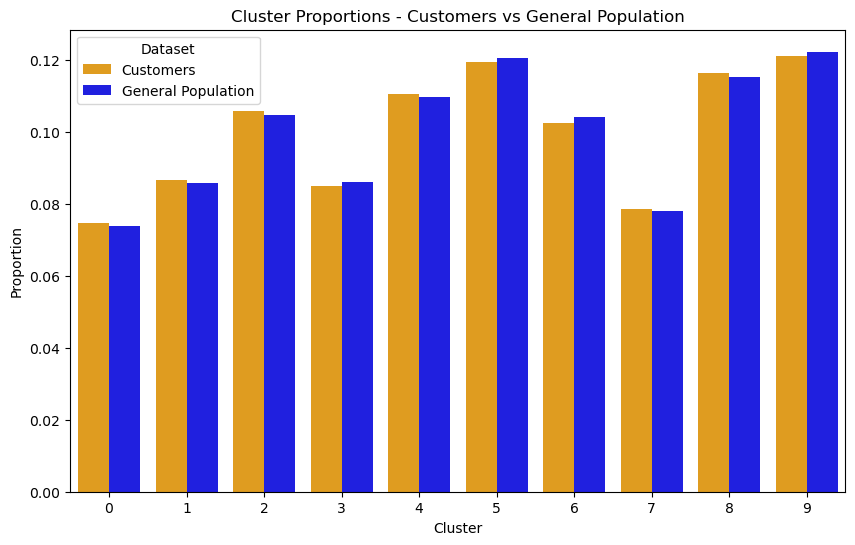

In [84]:
# Convert the arrays to Pandas Series
customer_series = pd.Series(customer_proportions, name='Customers')
general_population_series = pd.Series(general_population_proportions, name='General Population')

# Combine customer and general population cluster proportions
combined_proportions = pd.concat([customer_series, general_population_series], axis=1)
combined_proportions['Clusters'] = combined_proportions.index

# Melt the data for plotting
melted_proportions = pd.melt(combined_proportions, id_vars='Clusters', var_name='Dataset', value_name='Proportion')

# Plot the cluster proportions
plt.figure(figsize=(10, 6))
sns.barplot(x='Clusters', y='Proportion', hue='Dataset', data=melted_proportions, palette=['orange', 'blue'])
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.title('Cluster Proportions - Customers vs General Population')
plt.legend(title='Dataset')
plt.show()

In [85]:
# Create a DataFrame to hold the cluster proportions for both datasets
cluster_comparison = pd.DataFrame({'General Population': general_population_proportions,
                                   'Customers': customer_proportions})

# Export the DataFrame to a CSV file
cluster_comparison.to_csv('cluster_proportions.csv', index_label='Cluster')

In [86]:
cluster_comparison.head(10)

,General Population,Customers
0,0.073805,0.074532
1,0.085706,0.086617
2,0.104558,0.105824
3,0.086096,0.084897
4,0.109720,0.110453
5,0.120605,0.119433
6,0.103985,0.102515
7,0.078007,0.078399
8,0.115301,0.116410
9,0.122217,0.120921


### Discussion 3.3: Compare Customer Data to Demographics Data

Based on the clustering analysis, I have identified segments of the population that are relatively popular or unpopular with the mail-order company. By comparing the cluster proportions of the general population and the customer data, we can draw conclusions about the segments that are overrepresented or underrepresented among the company's customers.

Overrepresented Clusters: These are segments of the population that are relatively popular with the mail-order company. The customers belonging to these clusters are more likely to engage with the company's products or services. They represent a higher proportion in the customer dataset compared to the general population. The characteristics of these clusters can provide valuable insights for targeted marketing strategies.

Underrepresented Clusters: These are segments of the population that are relatively unpopular with the mail-order company. The customers belonging to these clusters are less likely to be the company's customers. They represent a lower proportion in the customer dataset compared to the general population. Exploring the reasons behind the lower representation of these clusters can help identify potential areas for improvement or untapped market segments.

By understanding the characteristics of the overrepresented clusters, the mail-order company can tailor their marketing efforts to target similar individuals or segments in the general population. This can involve creating targeted campaigns, personalized offers, or developing products/services that align with the preferences and needs of these segments.

Conversely, investigating the characteristics of the underrepresented clusters can provide insights into potential opportunities for expanding the customer base. By understanding the factors that make these segments relatively unpopular, the company can identify areas for improvement or develop strategies to attract individuals from these segments.

The clustering analysis provides a foundation for understanding the customer segments that are relatively popular or unpopular with the mail-order company. However, further analysis and interpretation of the specific cluster characteristics, demographics, and behavior patterns are necessary to develop actionable insights and formulate effective marketing strategies.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.